Using device: cuda


100%|██████████| 938/938 [00:19<00:00, 47.88it/s]


[Epoch 5/50] [D loss: 0.253760] [G loss: 3.279937]


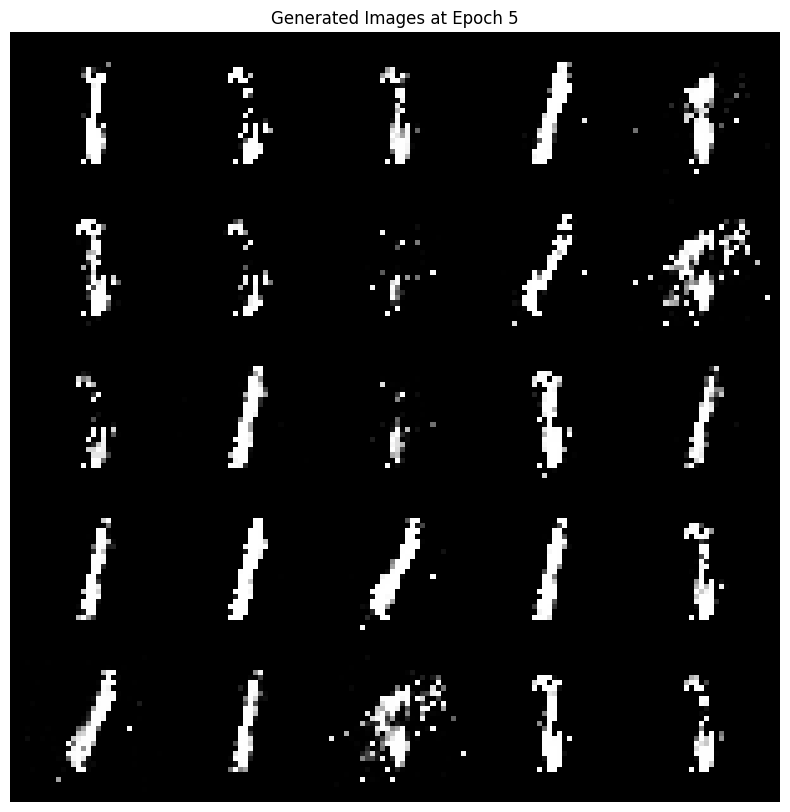

100%|██████████| 938/938 [00:19<00:00, 47.15it/s]


[Epoch 10/50] [D loss: 1.170570] [G loss: 2.025862]


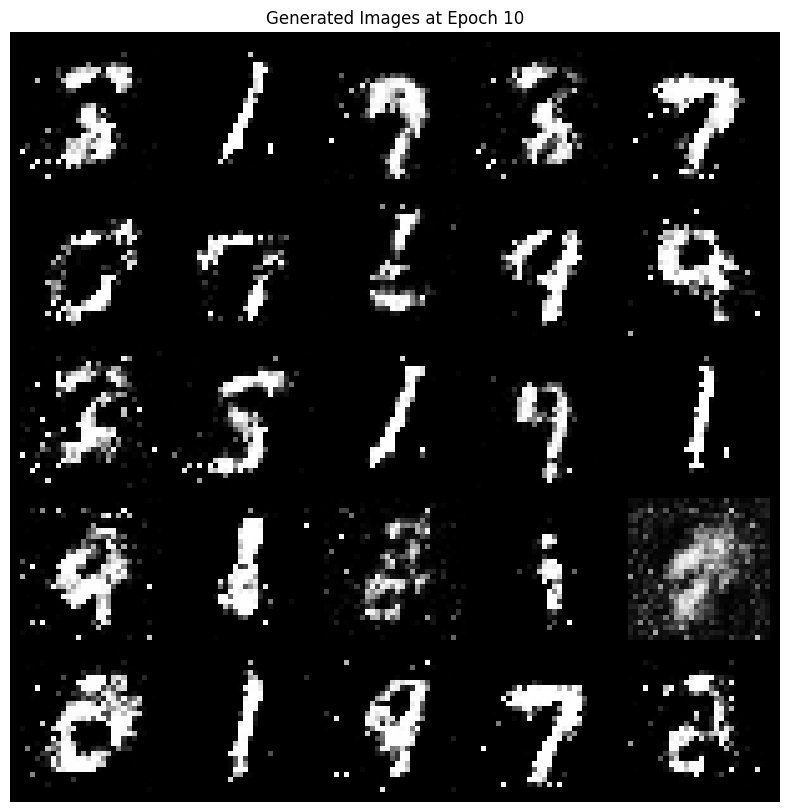

100%|██████████| 938/938 [00:19<00:00, 47.40it/s]


[Epoch 15/50] [D loss: 1.078768] [G loss: 1.856961]


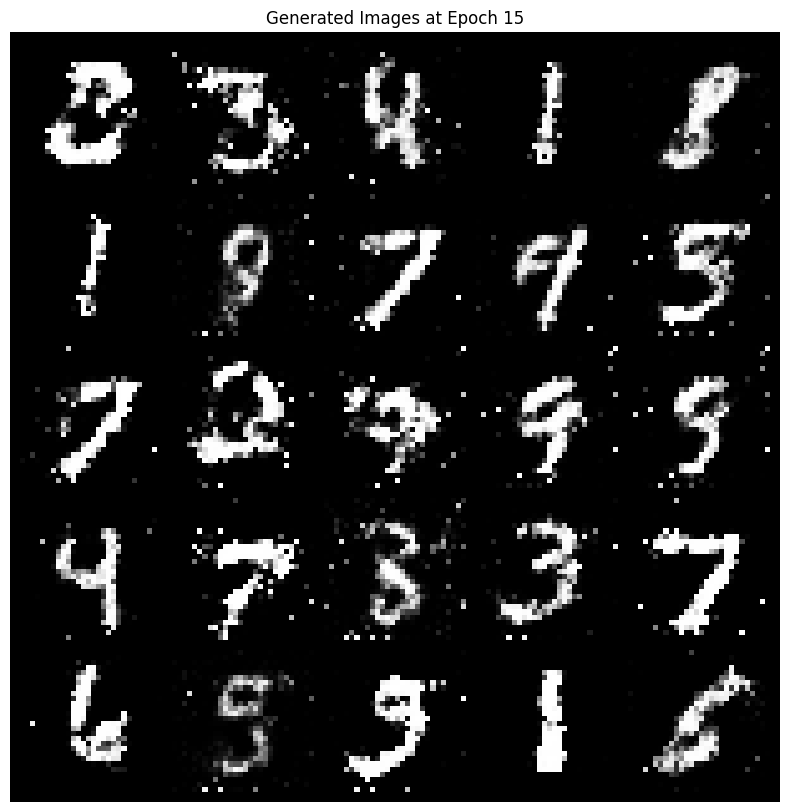

100%|██████████| 938/938 [00:20<00:00, 45.45it/s]


[Epoch 20/50] [D loss: 1.087128] [G loss: 1.193132]


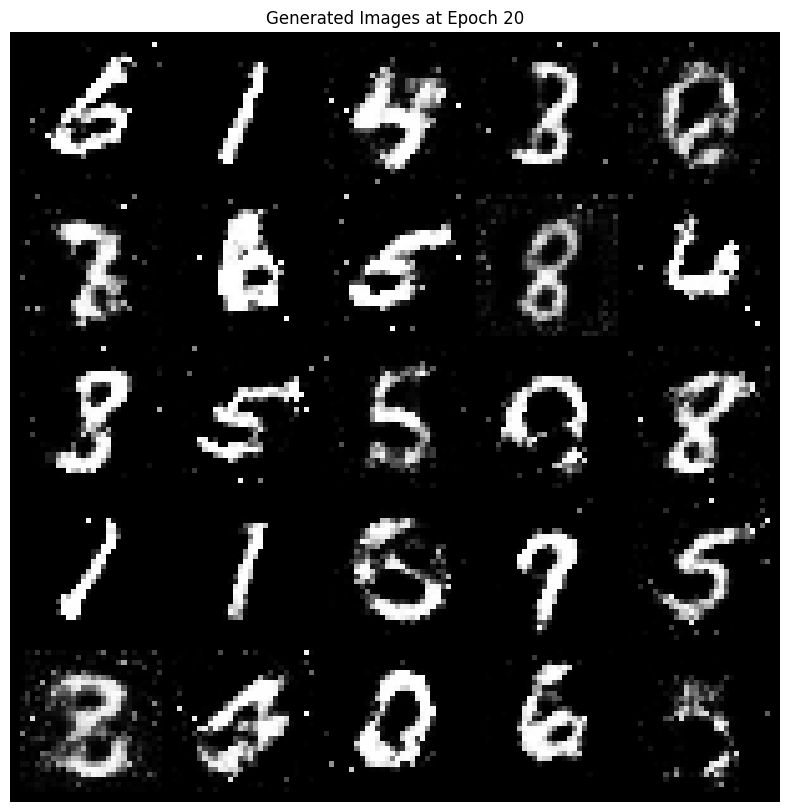

100%|██████████| 938/938 [00:19<00:00, 47.85it/s]


[Epoch 25/50] [D loss: 1.091219] [G loss: 1.261281]


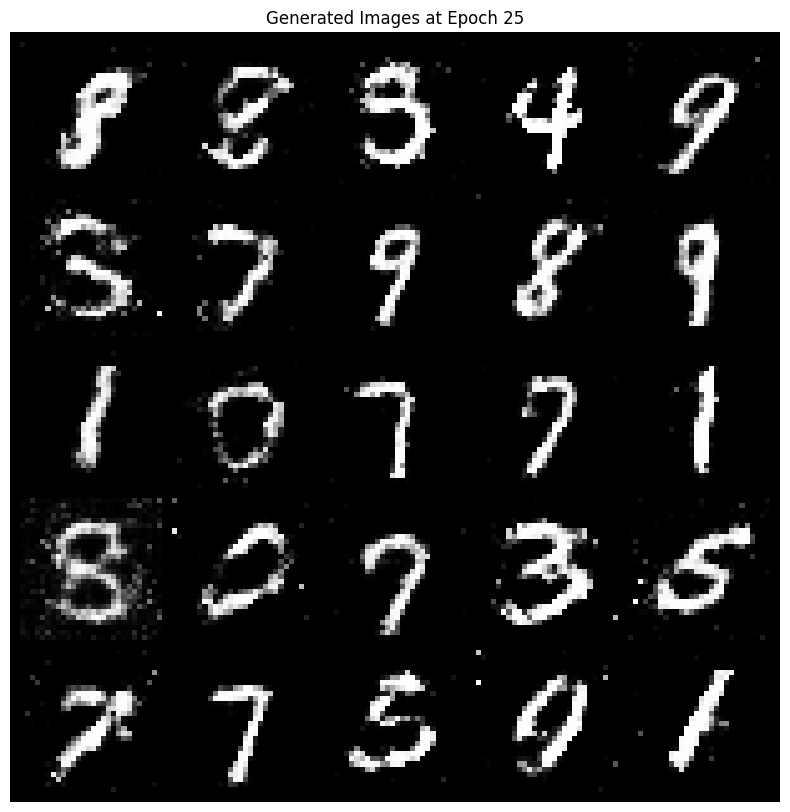

100%|██████████| 938/938 [00:20<00:00, 45.99it/s]


[Epoch 30/50] [D loss: 1.052262] [G loss: 1.200940]


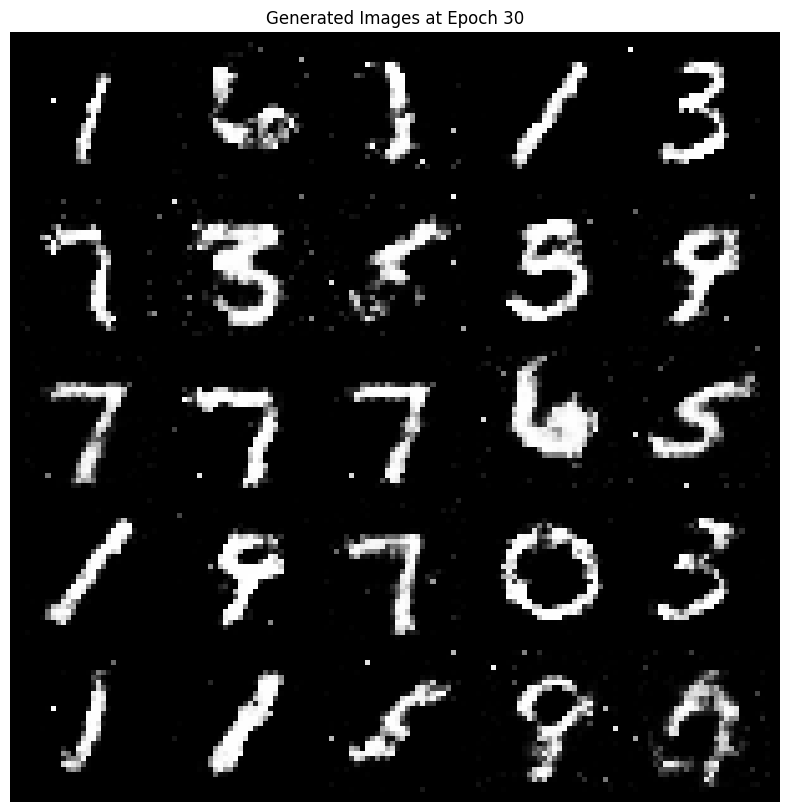

100%|██████████| 938/938 [00:20<00:00, 44.78it/s]


[Epoch 35/50] [D loss: 1.266472] [G loss: 1.192147]


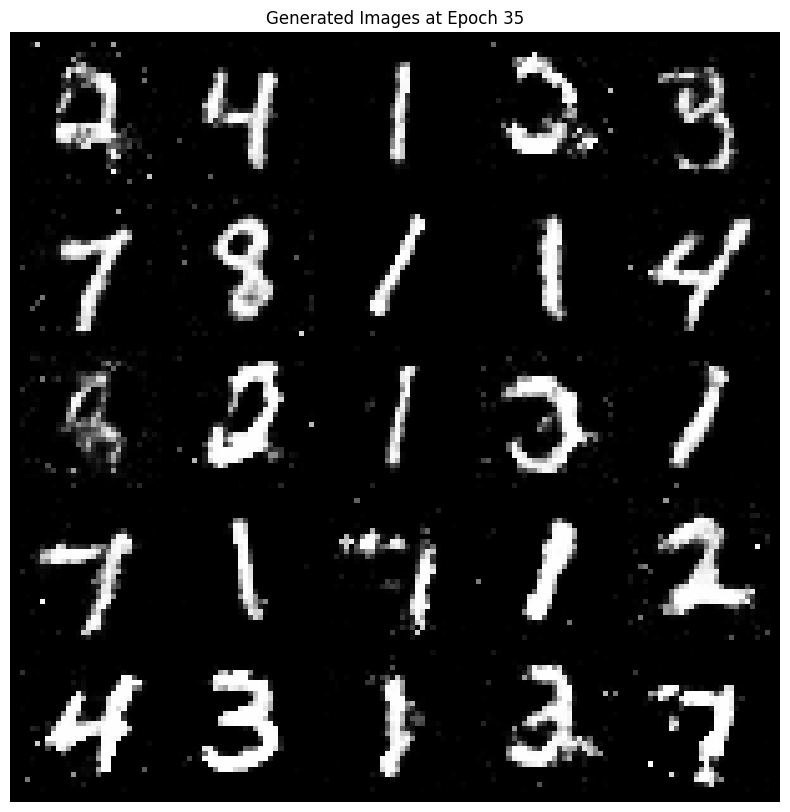

100%|██████████| 938/938 [00:20<00:00, 46.17it/s]


[Epoch 40/50] [D loss: 1.067200] [G loss: 1.112395]


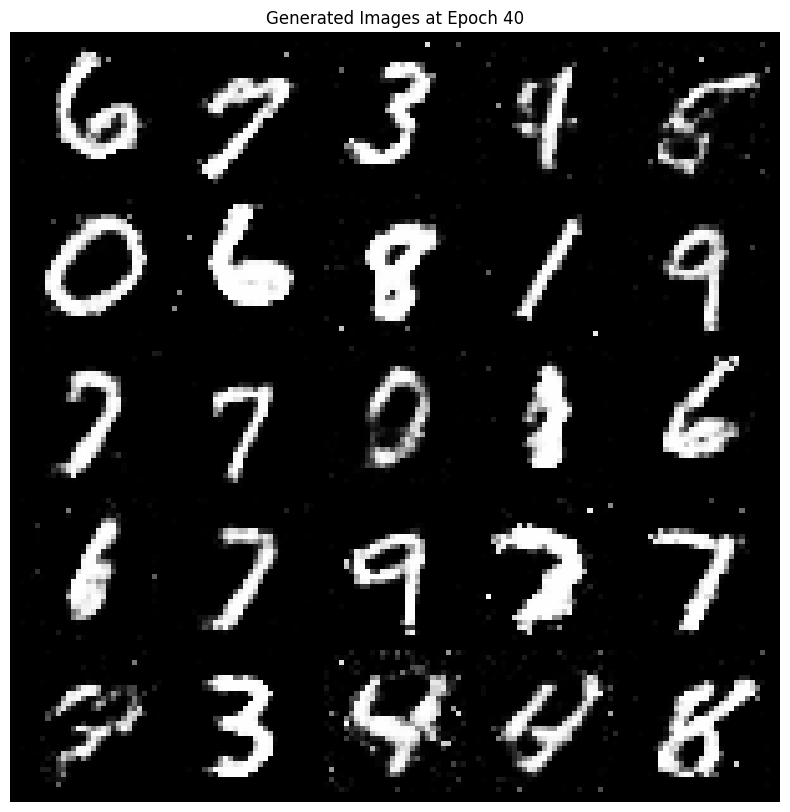

100%|██████████| 938/938 [00:21<00:00, 44.24it/s]


[Epoch 45/50] [D loss: 1.320323] [G loss: 1.022622]


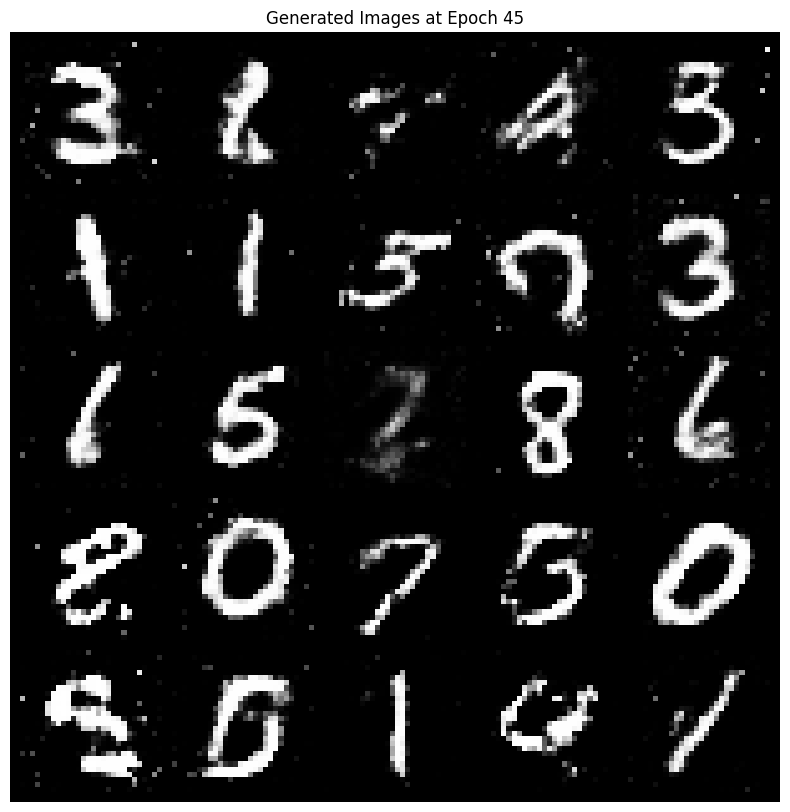

100%|██████████| 938/938 [00:20<00:00, 46.63it/s]


[Epoch 50/50] [D loss: 1.039549] [G loss: 1.278100]


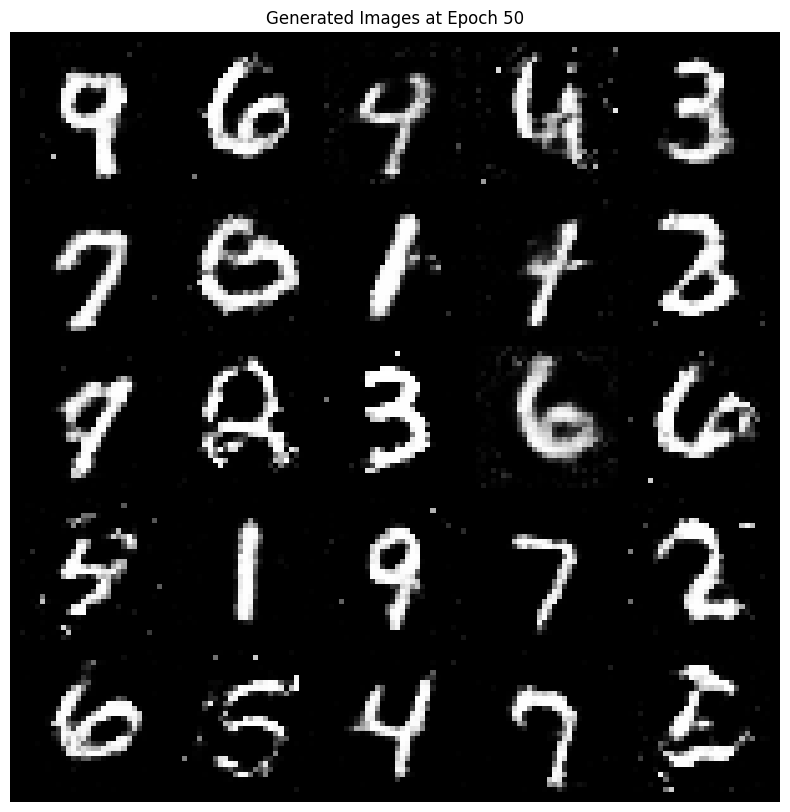

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Hyperparameters
latent_dim = 100
batch_size = 64
num_epochs = 50

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, z):
        return self.main(z).view(-1, 1, 28, 28)

# Define Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(784, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

# Initialize models
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Loss function
adversarial_loss = nn.BCELoss()

# Create directory for saving generated images
os.makedirs('images', exist_ok=True)

# Training Loop
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(tqdm(train_loader)):
        valid = torch.ones((images.shape[0], 1)).to(device)
        fake = torch.zeros((images.shape[0], 1)).to(device)

        real_imgs = images.to(device)
        noise = torch.randn(images.shape[0], latent_dim, device=device)

        # Train Discriminator
        optimizer_D.zero_grad()
        real_pred = discriminator(real_imgs)
        d_loss_real = adversarial_loss(real_pred, valid)
        d_loss_real.backward()

        fake_imgs = generator(noise)
        fake_pred = discriminator(fake_imgs)
        d_loss_fake = adversarial_loss(fake_pred, fake)
        d_loss_fake.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        fake_imgs = generator(noise)
        pred = discriminator(fake_imgs)
        g_loss = adversarial_loss(pred, valid)
        g_loss.backward()
        optimizer_G.step()

    # Save generated images every 5 epochs and plot a grid of images
    if (epoch + 1) % 5 == 0:
        print(f'[Epoch {epoch + 1}/{num_epochs}] [D loss: {d_loss_real.item() + d_loss_fake.item():.6f}] [G loss: {g_loss.item():.6f}]')

        # Save image grid
        save_image(fake_imgs.data[:25], f'images/mnist_{epoch + 1}.png', nrow=5, normalize=True)

        # Plot grid of generated images
        grid = torchvision.utils.make_grid(fake_imgs.data[:25], nrow=5, normalize=True, padding=2)
        plt.figure(figsize=(10, 10))
        plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
        plt.axis('off')
        plt.title(f'Generated Images at Epoch {epoch + 1}')
        plt.show()

# Save trained models
torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')
